# Perceptron Multicapa

Hasta aquí hemos trabajado con modelos lineales o modelos de una sola capa. Es fácil entender porque estos modelos simples pueden fallar. Por ejemplo, hay fenómenos que pueden tener ciclos o frecuencias asociadas. O pueden existir situaciones donde una de nuestras categorías caiga en un rango acotado de valores (por ejemplo cantidad saludable de azucar en sangre)

Esto nos da a entender que debemos considerar más que solo modelos lineales

### Agregando capas ocultas

![](http://d2l.ai/_images/mlp.svg)

Sin embargo este modelo sigue siendo lineal:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}. \\
    \mathbf{O} & = [\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}]\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    \mathbf{O} & = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    \mathbf{O} & = \mathbf{X} \mathbf{W'} + \mathbf{b'} + \mathbf{b}^{(2)}\\
    \mathbf{O} & = \mathbf{X} \mathbf{W'} + \mathbf{b''}
\end{aligned}
$$

Si queremos un modelo más general, debemos usar algo más que solo capas lineales.

Para esto introducimos **funciones de activación**

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$


## Funciones de activacion 


In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np

A continuación graficaremos algunas funciones de activación y sus respectivas derivadas

### ReLU

$$\operatorname{ReLU}(x) = \max(0, x)$$


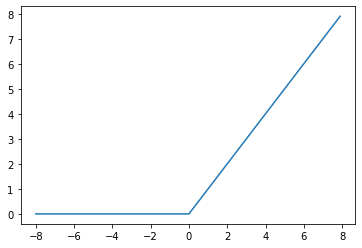

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plt.plot(x.detach(), y.detach())

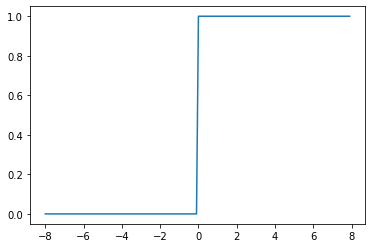

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
plt.plot(x.detach(), x.grad)

Existen varias alternativas similares a ReLU, sin embargo, queremos destactar a pReLU. A diferencia de ReLU, pReLU no descarta el gradiente a la izquierda. Además, el peso que se le otorgoa al gradiente a la izquierda es parte de los parámetros del modelo.

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoidea

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

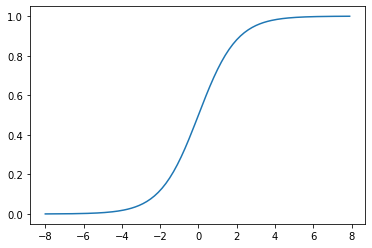

In [ ]:
y = torch.sigmoid(x)
plt.plot(x.detach(), y.detach())

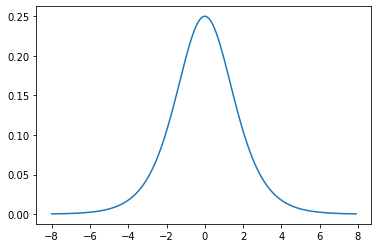

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad)

### Tangente hiperbólica

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

$$\operatorname{tanh}(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}.$$

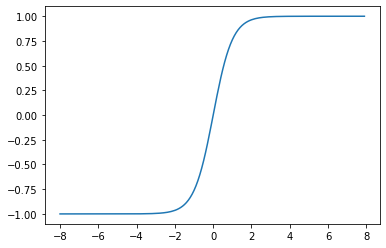

In [ ]:
y = torch.tanh(x)
plt.plot(x.detach(), y.detach())

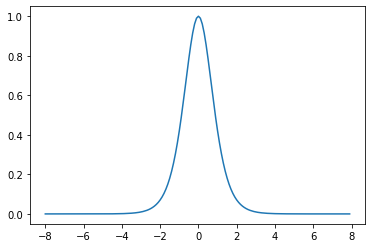

In [ ]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad)

# Implementación de un perceptrón multicapa desde 0



In [ ]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

In [ ]:
#Ejemplo de dataloader para FAshin MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Como ven, vamos a volver a usar Fashion MNIST

## Inicialización de parametros.


In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## Función de activación


In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## Modelo


In [ ]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # '@' multiplicacion de matrices
    return (H@W2 + b2)

## Función de pérdida


In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

Recordemos que vamos a usar de nuevo la exactitud

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

## Entrenamiento


In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

In [ ]:
num_epochs = 10
lr = 0.1
#features, labels = test_iter
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        L += l.sum()
        # Aca el número de ejemplos
        N += l.numel()
        # Aca calcuamos exatitud
        Acc += accuracy(net(X), y)
    for X, y in train_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 1.048496          , train accuracy  0.663483, test accuracy 0.761983
epoch 2, loss 0.603957          , train accuracy  0.800083, test accuracy 0.802183
epoch 3, loss 0.526677          , train accuracy  0.828700, test accuracy 0.787783
epoch 4, loss 0.483153          , train accuracy  0.844167, test accuracy 0.779667
epoch 5, loss 0.457121          , train accuracy  0.852217, test accuracy 0.843683
epoch 6, loss 0.436909          , train accuracy  0.858217, test accuracy 0.842267
epoch 7, loss 0.419260          , train accuracy  0.864417, test accuracy 0.859267
epoch 8, loss 0.405349          , train accuracy  0.868833, test accuracy 0.843200
epoch 9, loss 0.392826          , train accuracy  0.872417, test accuracy 0.857350
epoch 10, loss 0.383630          , train accuracy  0.876550, test accuracy 0.846500


# Implementacion concisa


In [ ]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

## Modelo


In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
#Ejemplo de dataloader para FAshin MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [ ]:
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(net(X), y)
    for X, y in train_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 1.043358          , train accuracy  0.652750, test accuracy 0.767400
epoch 2, loss 0.597148          , train accuracy  0.802800, test accuracy 0.799967
epoch 3, loss 0.516236          , train accuracy  0.829700, test accuracy 0.829250
epoch 4, loss 0.482279          , train accuracy  0.842317, test accuracy 0.829217
epoch 5, loss 0.453122          , train accuracy  0.853617, test accuracy 0.847067
epoch 6, loss 0.433274          , train accuracy  0.859867, test accuracy 0.848600
epoch 7, loss 0.417155          , train accuracy  0.864267, test accuracy 0.860633
epoch 8, loss 0.402176          , train accuracy  0.870150, test accuracy 0.861300
epoch 9, loss 0.392743          , train accuracy  0.873783, test accuracy 0.861333
epoch 10, loss 0.382439          , train accuracy  0.877067, test accuracy 0.860050


# Eliminar?

Ejercicio: Generar un modelos perceptron multicapa con una exactitud mayor a 90% para el conjunto de prueba. Intente variar los valores de tasa de aprendizaje, número de capas y el número de entradas y salida de cada capa.

> **Ayuda**: puede ser útil usar más de 10 épocas.

In [ ]:
INPUT = 28 * 28
OUTPUT = 10
HIDDEN1 = 512
HIDDEN2 = 128
batch_size, lr, num_epochs = 256, 0.3, 20

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(INPUT, HIDDEN1),
                    nn.ReLU(),
                    nn.Linear(HIDDEN1, HIDDEN2),
                    nn.ReLU(),
                    nn.Linear(HIDDEN2, OUTPUT))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

train_iter, test_iter = load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

for i in range(20):
  print(f"try {i}")
  net.apply(init_weights);
  for epoch in range(num_epochs):
      L = 0.0
      N = 0
      Acc = 0.0
      TestAcc = 0.0
      TestN = 0
      for X, y in train_iter:
          l = loss(net(X) ,y)
          trainer.zero_grad()
          l.mean().backward()
          trainer.step()
          L += l.sum()
          N += l.numel()
          Acc += accuracy(net(X), y)
      for X, y in train_iter:
          TestN += y.numel()
          TestAcc += accuracy(net(X), y)
      print(f'epoch {epoch + 1}, loss {(L/N):f}\
            , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

try 0
epoch 1, loss 1.196911            , train accuracy  0.559700, test accuracy 0.715300
epoch 2, loss 0.570896            , train accuracy  0.805333, test accuracy 0.824017
epoch 3, loss 0.467802            , train accuracy  0.847883, test accuracy 0.765550
epoch 4, loss 0.421502            , train accuracy  0.867567, test accuracy 0.797783
epoch 5, loss 0.385699            , train accuracy  0.878433, test accuracy 0.835200
epoch 6, loss 0.367093            , train accuracy  0.888117, test accuracy 0.865883
epoch 7, loss 0.347144            , train accuracy  0.894183, test accuracy 0.878300
epoch 8, loss 0.332436            , train accuracy  0.901950, test accuracy 0.863783
epoch 9, loss 0.319932            , train accuracy  0.903683, test accuracy 0.878850
epoch 10, loss 0.308833            , train accuracy  0.909400, test accuracy 0.825550
epoch 11, loss 0.361338            , train accuracy  0.897350, test accuracy 0.892100
epoch 12, loss 0.300831            , train accuracy  0.91